<a href="https://colab.research.google.com/github/amita-kapoor/COVID-2020/blob/master/Prediction_Covid_19_WorldWide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid 19 cases World Wide Analysis 
Data Source: https://github.com/CSSEGISandData/COVID-19

In [33]:
!pip install geopandas

In [0]:
from datetime import timedelta, date
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


# Read data 
Data source: [CSSEGISandData](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data)

In [0]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2020, 1, 22)
end_dt = date(2020, 3, 19)
dates = []
for dt in daterange(start_dt, end_dt):
    dates.append(dt.strftime("%m-%d-%Y"))


In [36]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'
df1 = pd.read_csv(url+dates[0]+'.csv')
for date in tqdm(dates):
  #print(url+date+'.csv')
  df2 = pd.read_csv(url+date+'.csv')
  df1 = pd.merge(df1, df2, how='outer' )

100%|██████████| 58/58 [00:02<00:00, 19.35it/s]


In [0]:
df1.drop(['Province/State'], axis=1, inplace=True)
df1['Last Update']= pd.to_datetime(df1['Last Update']) 
df1['Last Update'] = df1['Last Update'].dt.date
df1.fillna(0, inplace = True)

In [0]:
dict_country = {'Cote d\'Ivoire': 'Côte d\'Ivoire', 'Martinique':'France', 'Hong Kong':'China',
                'North Korea':'Korea, Democratic People\'s Republic of','Republic of Korea':'South Korea',
                'Korea, South': 'South Korea','US':'United States of America','UK':'United Kingdom',
                'Mainland China':'China','Iran (Islamic Republic of)':'Iran', 'Czech Republic': 'Czechia',
                'Hong Kong SAR': 'Hong Kong','Bosnia and Herzegovina': 'Bosnia and Herz.','Republic of Ireland':'Ireland',
                ' Azerbaijan':'Azerbaijan', 'Andorra':'Italy','Aruba':'Netherlands','Cayman Islands':'United Kingdom',
                'Central African Republic':'Central African Rep.','Channel Islands':'United Kingdom',
                'Congo (Brazzaville)':'Congo','Congo (Kinshasa)':'Congo','Viet Nam':'Vietnam',
                'Equatorial Guinea': 'Eq. Guinea', 'Eswatini':'eSwatini' ,'occupied Palestinian territory':'Palestine',
                'Vatican City':'Italy','The Bahamas':'Bahamas','Taiwan*':'Taiwan','Taipei and environs':'Taiwan','Holy See':'Italy',
                'Saint Martin':'St. Martin','Singapore':'China','Russian Federation':'Russia',
                'Republic of the Congo':'Congo','Republic of Moldova':'Moldova','North Macedonia':'Macedonia',
                'North Ireland':'United Kingdom','Monaco':'Others','Seychelles':'Others','Saint Vincent and the Grenadines':'Others',
                'Antigua and Barbuda':'Others','Bahrain':'Others','Cruise Ship':'Others', 'Curacao':'Others','Dominican Republic':'Dominican Rep.',
                'Faroe Islands': 'Others', 'French Guiana':'Others','Gibraltar':'Others','Guadeloupe':'Others','Guam':'Others','Ivory Coast':'Côte d\'Ivoire'}
for key, value in dict_country.items():
  df1['Country/Region'].replace([key], value,inplace=True)

In [39]:
df1.head()

,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,China,2020-01-22,1.0,0.0,0.0,0.0,0.0
1,China,2020-01-22,14.0,0.0,0.0,0.0,0.0
2,China,2020-01-22,6.0,0.0,0.0,0.0,0.0
3,China,2020-01-22,1.0,0.0,0.0,0.0,0.0
4,China,2020-01-22,0.0,0.0,0.0,0.0,0.0


In [40]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4595 entries, 0 to 4594
Data columns (total 7 columns):
Country/Region    4595 non-null object
Last Update       4595 non-null object
Confirmed         4595 non-null float64
Deaths            4595 non-null float64
Recovered         4595 non-null float64
Latitude          4595 non-null float64
Longitude         4595 non-null float64
dtypes: float64(5), object(2)
memory usage: 287.2+ KB


In [0]:
df1 = pd.pivot_table(df1, index=['Country/Region','Last Update'], aggfunc={'Confirmed':np.sum, 'Deaths':np.sum,\
                                                                           'Recovered':np.sum,'Latitude':np.max,\
                                                                           'Longitude':np.max})

In [42]:
df1.head(10)


Confirmed  Deaths  Latitude  Longitude  Recovered
Country/Region Last Update                                                   
Afghanistan    2020-02-24         1.0     0.0   33.0000    65.0000        0.0
               2020-03-08         4.0     0.0   33.0000    65.0000        0.0
               2020-03-10         5.0     0.0   33.0000    65.0000        0.0
               2020-03-11        14.0     0.0   33.0000    65.0000        0.0
               2020-03-14        11.0     0.0   33.9391    67.7100        0.0
               2020-03-15        16.0     0.0   33.9391    67.7100        0.0
               2020-03-16        21.0     0.0   33.9391    67.7100        1.0
               2020-03-17        22.0     0.0   33.9391    67.7100        1.0
Albania        2020-03-09         2.0     0.0   41.1533    20.1683        0.0
               2020-03-10        10.0     0.0   41.1533    20.1683        0.0

In [0]:
def plot_percent(df_country, Country):
  ## Plotting the percentage
  plt.rcParams.update({'font.size': 22})
  plt.rcParams["figure.figsize"] = [16,10]
  plt.rc('xtick',labelsize=14, )
  plt.rc('ytick',labelsize=14)
  ax = df_country.plot('Last Update', ['deceased_percent', 'recovered_percent'])
  #ax = df_country.plot('Last Update', 'deceased_percent')
  ax.set_ylabel("Percentage", fontname="Arial", fontsize=18)
  ax.set_xlabel("Date", fontname="Arial", fontsize=18)
  ax.legend(loc=0, prop={'size': 20})
  ax.set_title("Percentage deceased, recovered and severe in "+ Country, fontsize=20)
  plt.xticks(rotation=45)

In [0]:
def plot_total(df_country, Country, bar=False):
  plt.rcParams.update({'font.size': 22})
  plt.rcParams["figure.figsize"] = [16,10]
  plt.rc('xtick',labelsize=14, )
  plt.rc('ytick',labelsize=14)
  df_country['Active'] = (df_country['Confirmed']- df_country['Deaths']-df_country['Recovered'])
  
  if bar:
    ax = df_country.plot.bar(x='Last Update', y=['Active', 'Recovered', 'Deaths'],stacked=True)
  else:
    ax = df_country.plot('Last Update', ['Active', 'Recovered', 'Deaths'])
  ax.set_ylabel("Number", fontname="Arial", fontsize=18)
  ax.set_xlabel("Date", fontname="Arial", fontsize=18)
  ax.legend(loc=0, prop={'size': 20})
  ax.set_title("Active, Recovered and Deaths in  "+ Country, fontsize=20)
  plt.xticks(rotation=45)

In [0]:
from scipy.optimize import curve_fit
def prediction_country(Country, df1, plot= False, plot_p = False, plot_t = False):
  df_final = df1.copy()
  df_country = df_final.loc[Country]
  df_country.reset_index(inplace=True)
    
  # Adding percentage of Deceased and ICU 

  df_country['deceased_percent'] = (df_country['Deaths']/ df_country['Confirmed'])*100
  df_country['recovered_percent'] = (df_country['Recovered']/ df_country['Confirmed'])*100
  df_country['active'] = (df_country['Confirmed']- df_country['Deaths']-df_country['Recovered'])

  if plot_p: plot_percent(df_country, Country)
  if plot_t: plot_total(df_country, Country)
  xdata=np.array(range(df_country.shape[0]))
  ydata=df_country['Confirmed'].values

  def func(x,a,b):
    return a*2**(x/b)
    
  try:
    popt, pcov = curve_fit(func,xdata=xdata,ydata=ydata)
    perr = np.sqrt(np.diag(pcov))
    resid = np.linalg.norm(ydata-func(xdata, *popt))
  except:
    popt = np.array([0,0])
  #print("For {} the coefficients of function is \n {} * 2 ** (t/{}) \n The covariance is:\n {} \n and the error is {}".format(Country,popt[0], popt[1], pcov, resid))

  if plot:
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = popt[0]*2**(xdata/popt[1])
    perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
    ax1.legend(fontsize=15)
    plt.show()
  return [Country, df_country['Last Update'][0],df_country['Confirmed'].iloc[-1], df_country['active'].iloc[-1],\
          df_country['deceased_percent'].iloc[-1], df_country['recovered_percent'].iloc[-1],popt[1], \
          df_country['Latitude'].iloc[-1],df_country['Longitude'].iloc[-1]] 



In [0]:
from scipy.optimize import curve_fit
def prediction_country2(Country, df1, plot=True):
  df_final = df1.copy()
  df_country = df_final.loc[Country]
  df_country.reset_index(inplace=True)

  x=np.array(range(df_country.shape[0]))
  y=df_country['Confirmed'].values
  print(len(x))

  def func(x,a,b):
    return a*2**(x/b)
  list_coeff = [Country]  
  for i in range(10, len(x), 1):
    xdata = x[:i]
    ydata = y[:i]

    try:
      popt, pcov = curve_fit(func,xdata=xdata,ydata=ydata)
    except:
      popt = np.array([0,0])
    list_coeff.append(popt[1])
  if plot:
    fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
    perc = np.diff(ydata) / ydata[:-1]
    yfit = popt[0]*2**(xdata/popt[1])
    perc_fit = np.diff(yfit) / yfit[:-1]
    ax1.set_ylabel('Total infected in '+ Country,fontsize=20)
    #ax1.set_yscale('log')
    ax1.plot(df_country['Confirmed'],'--o',ms=10,label='Real Data')
    ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
    ax1.legend(fontsize=15)
    plt.show()
  
  return list_coeff


In [0]:
Countries = ["China", "Italy", "Iran", "South Korea", "Germany", "United Kingdom",  "India", "Spain"]
#Countries = set(df1.reset_index()['Country/Region'].tolist())

  0%|          | 0/8 [00:00<?, ?it/s]

58


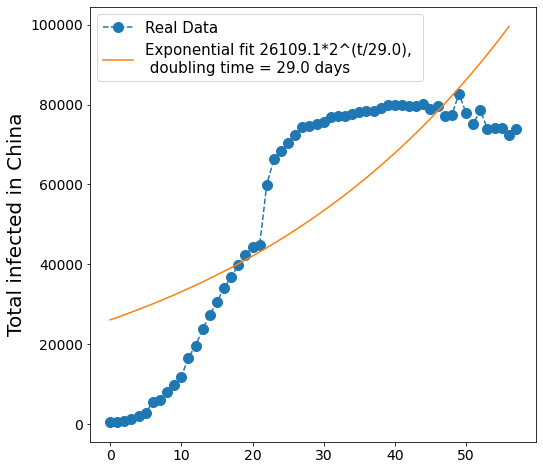

 12%|█▎        | 1/8 [00:00<00:02,  3.46it/s]

29


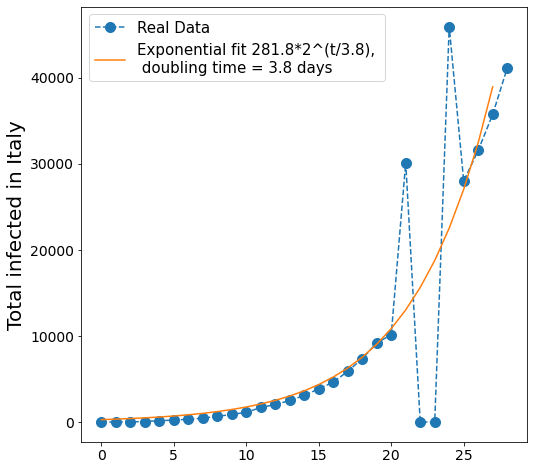

 25%|██▌       | 2/8 [00:00<00:01,  3.70it/s]

29


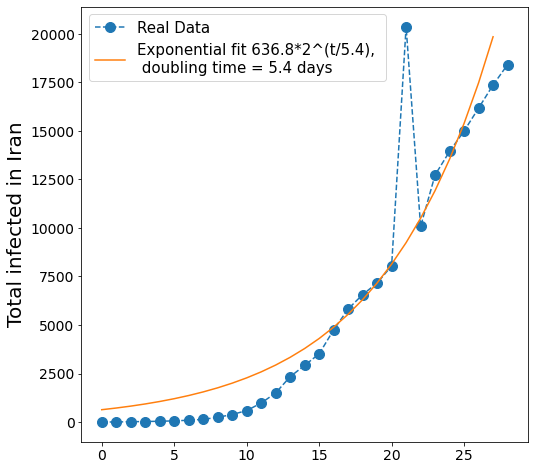

 38%|███▊      | 3/8 [00:00<00:01,  3.86it/s]

52


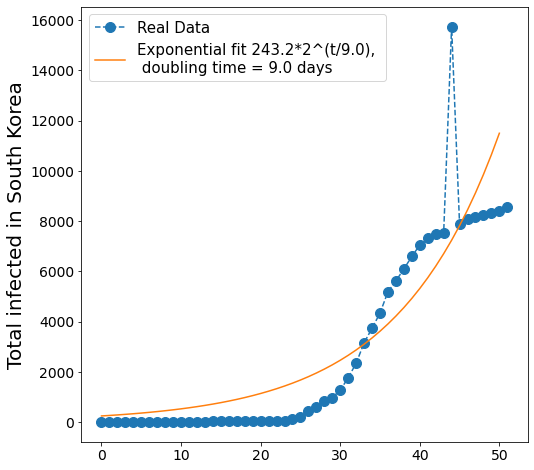

 50%|█████     | 4/8 [00:01<00:01,  3.82it/s]

36


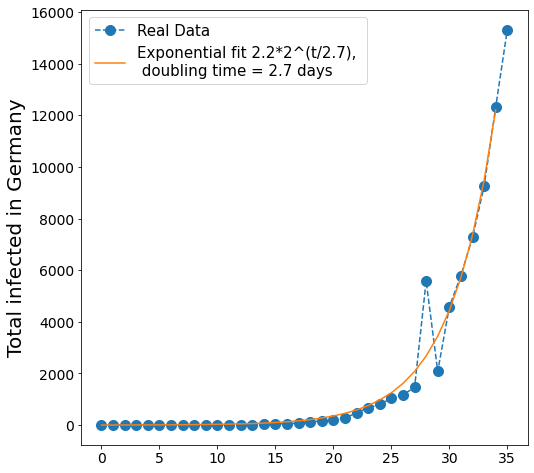

 62%|██████▎   | 5/8 [00:01<00:00,  3.93it/s]

28


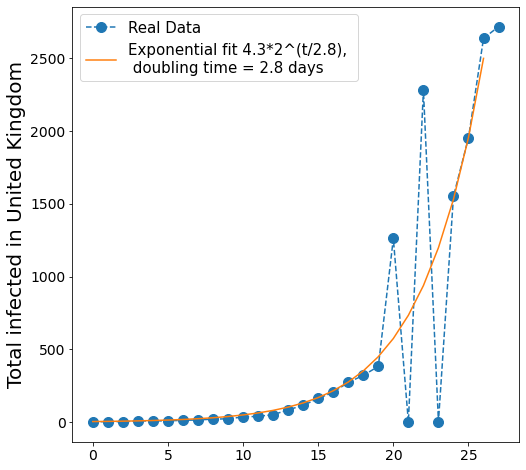

 75%|███████▌  | 6/8 [00:01<00:00,  4.15it/s]

22


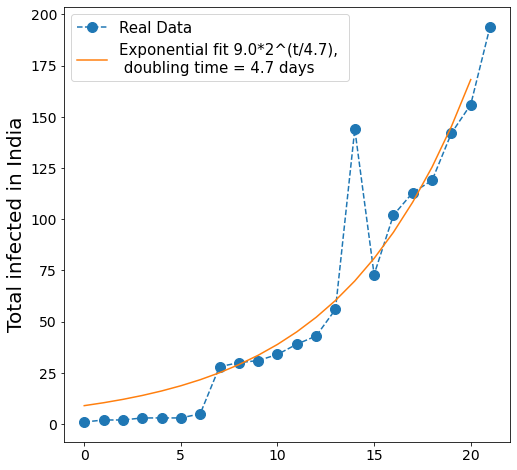

 88%|████████▊ | 7/8 [00:01<00:00,  4.27it/s]

26


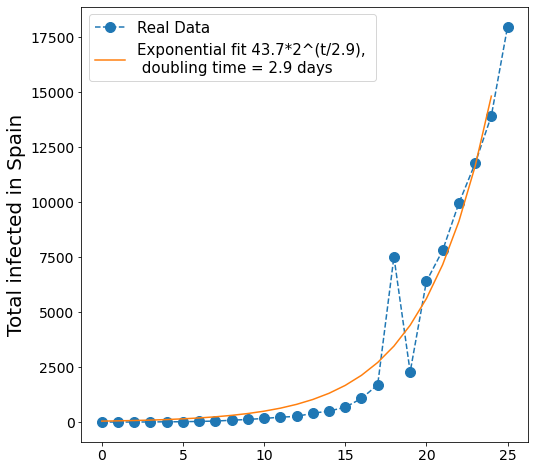

100%|██████████| 8/8 [00:01<00:00,  4.22it/s]


In [48]:
List = []
for Country in tqdm(Countries):
  List.append(prediction_country2(Country, df1))

In [0]:
df_combines = pd.DataFrame(List).T

In [0]:
df_combines.columns = df_combines.iloc[0]
df_combines.drop(df_combines.index[0], inplace=True)

In [51]:
df_combines

,China,Italy,Iran,South Korea,Germany,United Kingdom,India,Spain
1,2.37534,1.87864,1.46859,2.55368,4.24843,3.10638,1.85762,1.48148
2,2.62386,2.08684,1.52231,2.49846,4.86703,2.74167,2.36829,1.67929
3,2.59604,2.04362,1.47737,2.58495,5.62366,2.90559,2.78295,1.86263
4,2.74836,2.24987,1.51846,2.96266,6.47299,2.9572,3.19242,2.18377
5,2.91505,2.4616,1.54193,3.22009,7.1941,2.44257,3.32391,2.12714
6,3.13633,2.64228,1.81276,3.37612,6.31375,2.26426,1.84979,2.25684
7,3.42334,2.77371,2.12189,3.73351,4.38156,2.14719,3.12145,2.31254
8,3.71474,2.9302,2.25482,4.1678,3.99031,2.25832,3.52501,2.06932
9,4.05222,2.99397,2.44243,4.5711,2.94634,2.32871,3.88353,1.81643
10,4.39756,3.03018,2.73979,5.01976,2.03401,2.55562,4.28641,0.556929


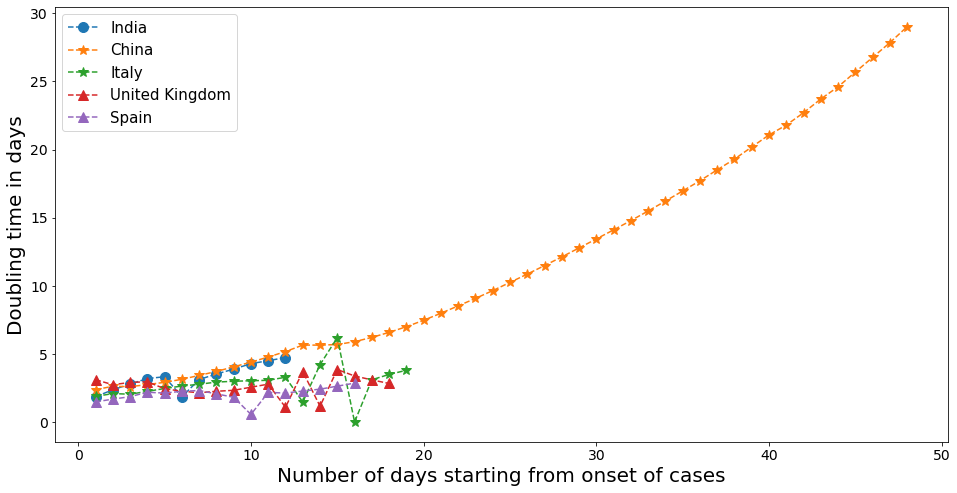

In [52]:
num = len(df_combines['India'])
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time in days',fontsize=20)
ax1.set_xlabel('Number of days starting from onset of cases',fontsize=20)
ax1.plot(df_combines['India'],'--o',ms=10,label='India')
ax1.plot(df_combines['China'].iloc[:num],'--*',ms=10,label='China')
#ax1.plot(df_combines['Germany'].iloc[:num],'--*',ms=10,label='Germany')
ax1.plot(df_combines['Italy'].iloc[:num],'--*',ms=10,label='Italy')
#ax1.plot(df_combines['Iran'].iloc[:num],'--^',ms=10,label='Iran')
ax1.plot(df_combines['United Kingdom'].iloc[:num],'--^',ms=10,label='United Kingdom')
ax1.plot(df_combines['Spain'].iloc[:num],'--^',ms=10,label='Spain')
ax1.legend(fontsize=15)
#plt.show()

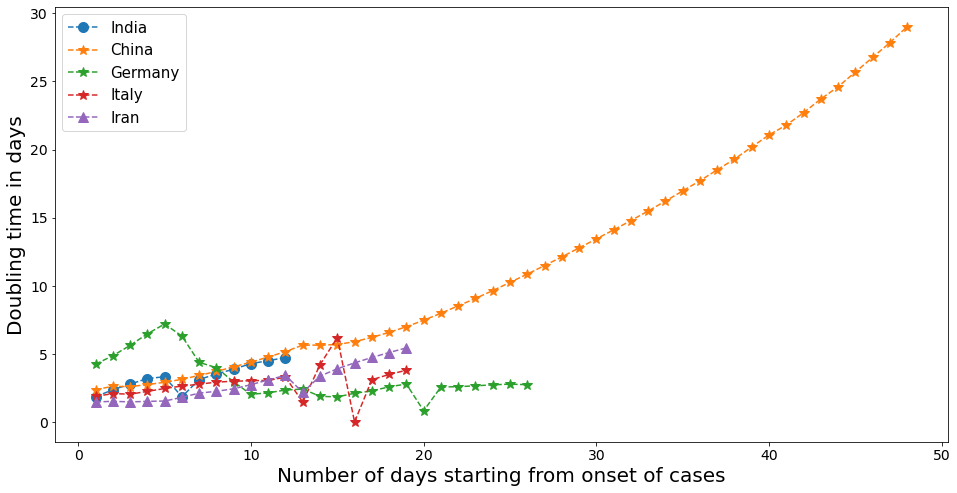

In [53]:
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time in days',fontsize=20)
ax1.set_xlabel('Number of days starting from onset of cases',fontsize=20)
ax1.plot(df_combines['India'],'--o',ms=10,label='India')
ax1.plot(df_combines['China'],'--*',ms=10,label='China')
ax1.plot(df_combines['Germany'],'--*',ms=10,label='Germany')
ax1.plot(df_combines['Italy'],'--*',ms=10,label='Italy')
ax1.plot(df_combines['Iran'],'--^',ms=10,label='Iran')
ax1.legend(fontsize=15)
#plt.show()

In [54]:
List = []
for Country in tqdm(Countries):
  List.append(prediction_country(Country, df1))

100%|██████████| 8/8 [00:00<00:00, 119.28it/s]


In [55]:
df_summary = pd.DataFrame(List, columns = ["Country", "First_Case", "Total_Confirmed_Today", "Active","Deceased_Percent",\
                                          "Recovered_Percent", "Doubling_time_in_days","Latitude", "Longitude"])
df_summary.head()

,Country,First_Case,Total_Confirmed_Today,Active,Deceased_Percent,Recovered_Percent,Doubling_time_in_days,Latitude,Longitude
0,China,2020-01-22,73954.0,7588.0,4.304027,85.435541,30.128718,47.8620,127.7615
1,Italy,2020-01-31,41088.0,33242.0,8.287091,10.808509,4.022953,42.5063,12.5674
2,Iran,2020-02-19,18407.0,11413.0,6.975607,31.020807,5.783860,32.4279,53.6880
3,South Korea,2020-01-22,8565.0,6934.0,1.062464,17.980152,9.549667,35.9078,127.7669
4,Germany,2020-01-28,15320.0,15163.0,0.287206,0.737598,2.783166,51.1657,10.4515


In [56]:
df_summary

,Country,First_Case,Total_Confirmed_Today,Active,Deceased_Percent,Recovered_Percent,Doubling_time_in_days,Latitude,Longitude
0,China,2020-01-22,73954.0,7588.0,4.304027,85.435541,30.128718,47.8620,127.7615
1,Italy,2020-01-31,41088.0,33242.0,8.287091,10.808509,4.022953,42.5063,12.5674
2,Iran,2020-02-19,18407.0,11413.0,6.975607,31.020807,5.783860,32.4279,53.6880
3,South Korea,2020-01-22,8565.0,6934.0,1.062464,17.980152,9.549667,35.9078,127.7669
4,Germany,2020-01-28,15320.0,15163.0,0.287206,0.737598,2.783166,51.1657,10.4515
5,United Kingdom,2020-01-31,2715.0,2510.0,5.082873,2.467772,3.104747,55.3781,-2.3644
6,India,2020-01-30,194.0,175.0,2.061856,7.731959,4.741417,20.5937,78.9629
7,Spain,2020-02-01,17963.0,16026.0,4.620609,6.162668,2.932709,40.4637,-3.7492


In [57]:
world_path = gpd.datasets.get_path('naturalearth_lowres')
World = gpd.read_file(world_path)
World.columns = ['pop_est', 'continent', 'Country', 'iso_a3', 'gdp_md_est', 'geometry']
print(len(World['Country']))
World = pd.merge(World, df_summary, on='Country',how='left')
World["Total_per_pop"] = World['Total_Confirmed_Today']/World['pop_est']*100
World.fillna(0,inplace=True)

177


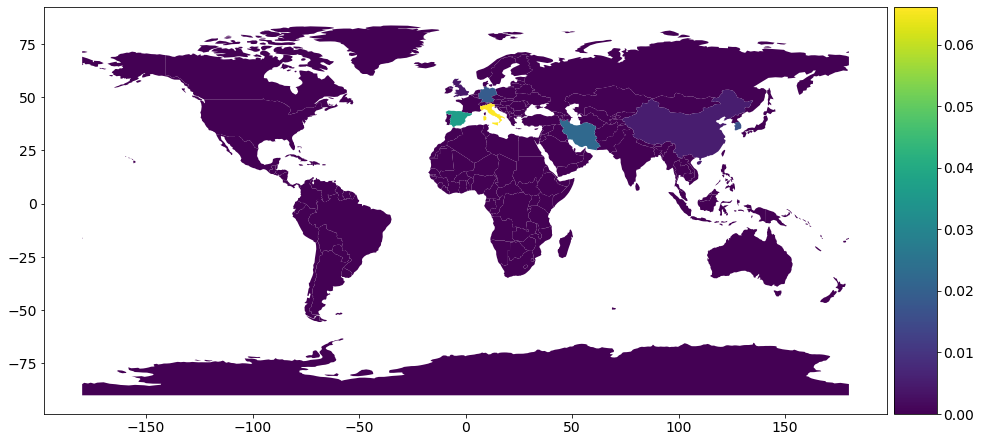

In [58]:
title = "Total_per_pop"
description = "Covid 19 cases world wide"
from mpl_toolkits.axes_grid1 import make_axes_locatable
#World = World[(World.Total_Confirmed_Today>10) & (World.Doubling_time_in_days < 30) & (World.Doubling_time_in_days > 0)]
fig, ax = plt.subplots(1, 1, figsize=(16,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
World.plot(column =title, ax=ax,
            legend=True, cax=cax)

In [0]:
Country = "India"
df_china = df1.loc[Country]
df_china.reset_index(inplace=True)
df_china.drop(df_china.tail(1).index,inplace=True)
df_china['active'] = (df_china['Confirmed']- df_china['Deaths']-df_china['Recovered'])
df_china['c-d'] = (df_china['Confirmed']- df_china['Deaths'])

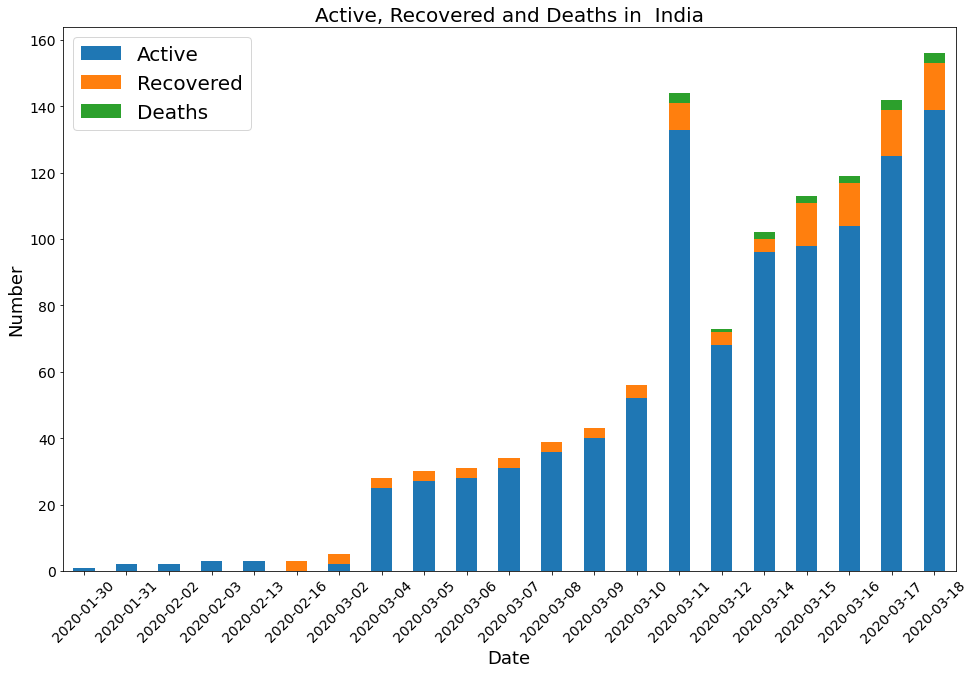

In [60]:
plot_total(df_china,Country,bar=True)

In [0]:
Country = "China"
df_china = df1.loc[Country]
df_china.reset_index(inplace=True)
df_china.drop(df_china.tail(1).index,inplace=True)
df_china['active'] = (df_china['Confirmed']- df_china['Deaths']-df_china['Recovered'])
df_china['c-d'] = (df_china['Confirmed']- df_china['Deaths'])
#df_china

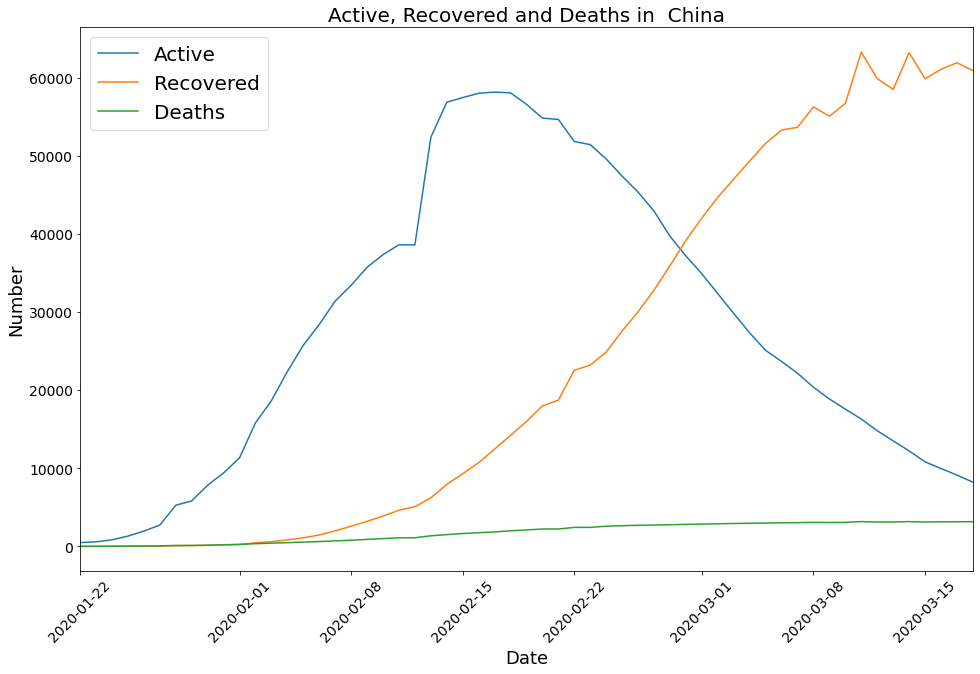

In [62]:
plot_total(df_china,Country)

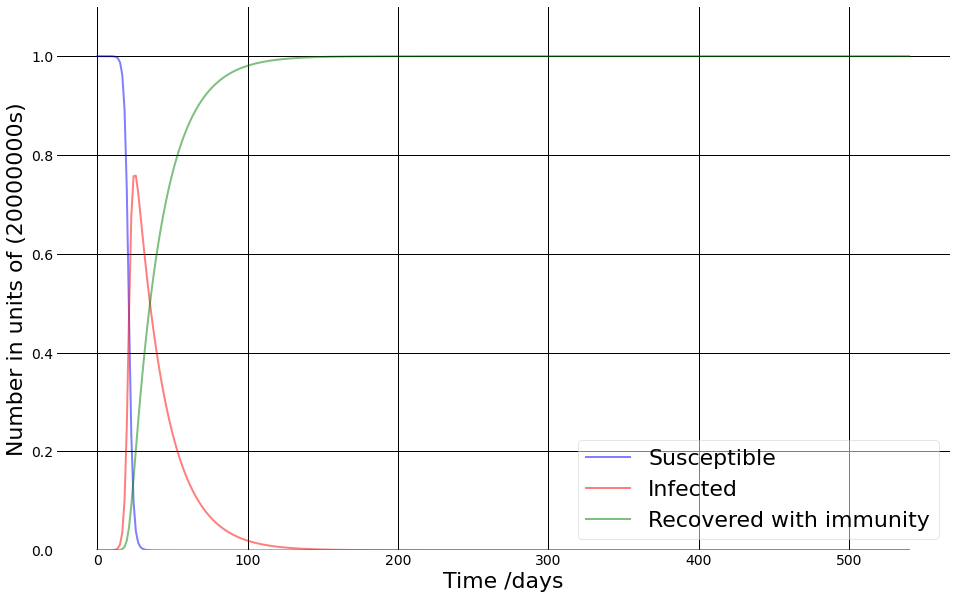

In [63]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 20000000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 3, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.8, 1/20    #  https://www.worldometers.info/coronavirus/coronavirus-incubation-period/#24
# A grid of time points (in days)
t = np.linspace(0, 540, 360)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number in units of ('+str(N)+'s)')
ax.set_ylim(0,1.1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='both',axis='both', c='black', lw=1, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

 # adapted code from:  https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

 # Reference: https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-contact-number

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text major ticklabel objects>)

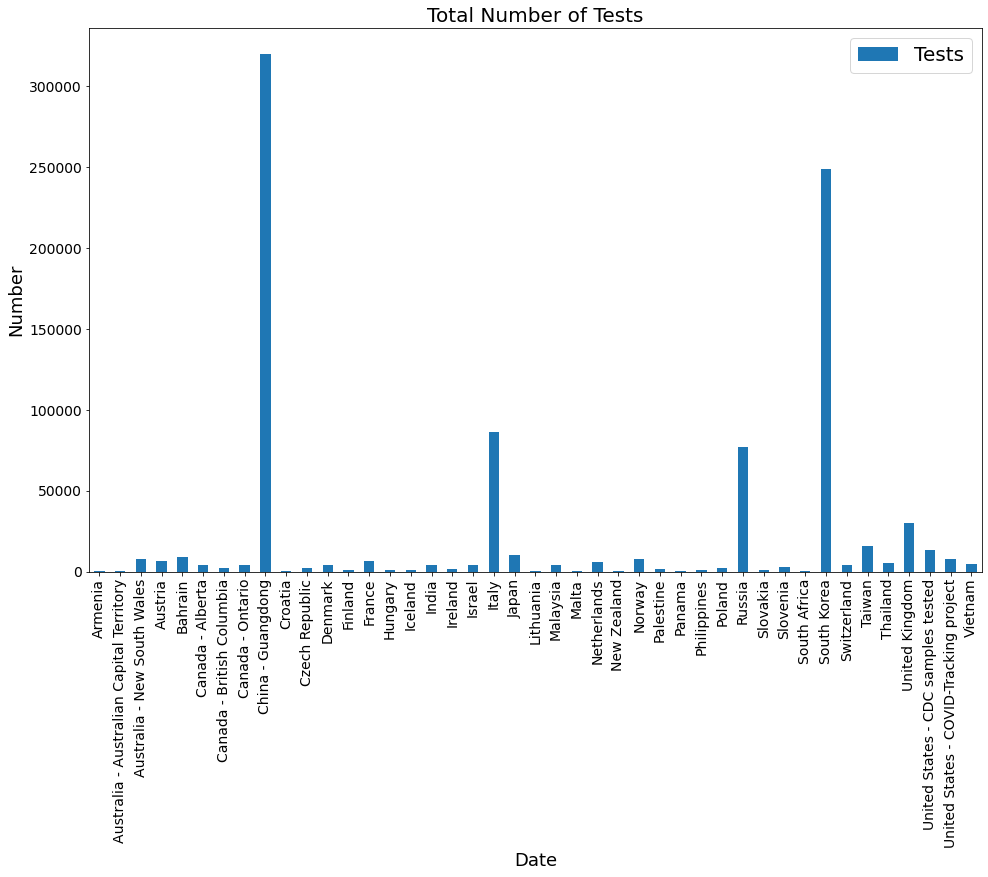

In [0]:
url_number_of_tests = 'https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/COVID-19%20Tests/COVID-19%20Tests.csv'
tests_df = pd.read_csv(url_number_of_tests )
tests_df.columns = ['Country','Year','Tests']
tests_df.set_index("Country", inplace = True)
tests_df.drop('Year', axis = 1, inplace = True)
ax = tests_df.plot.bar()
#ax = tests_df.plot.scatter(x='Country', y='Tests', s=tests_df['Tests'] * 200);
ax.set_ylabel("Number", fontname="Arial", fontsize=18)
ax.set_xlabel("Date", fontname="Arial", fontsize=18)
ax.legend(loc=0, prop={'size': 20})
ax.set_title("Total Number of Tests", fontsize=20)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text major ticklabel objects>)

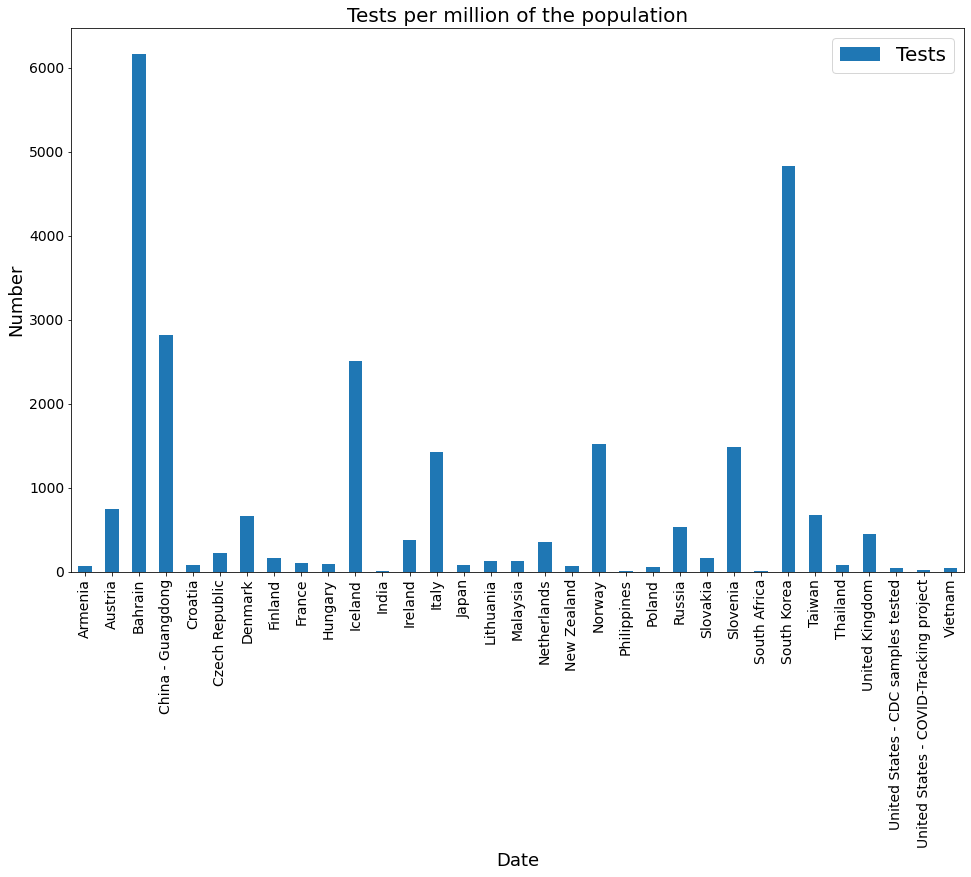

In [96]:
url_number_of_tests = 'https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/COVID-19%20Tests%20per%20million%20people/COVID-19%20Tests%20per%20million%20people.csv'
tests_df = pd.read_csv(url_number_of_tests )
tests_df.columns = ['Country','Year','Tests']
tests_df.set_index("Country", inplace = True)
tests_df.drop('Year', axis = 1, inplace = True)
ax = tests_df.plot.bar()
#ax = tests_df.plot.scatter(x='Country', y='Tests', s=tests_df['Tests'] * 200);
ax.set_ylabel("Number", fontname="Arial", fontsize=18)
ax.set_xlabel("Date", fontname="Arial", fontsize=18)
ax.legend(loc=0, prop={'size': 20})
ax.set_title("Tests per million of the population", fontsize=20)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text major ticklabel objects>)

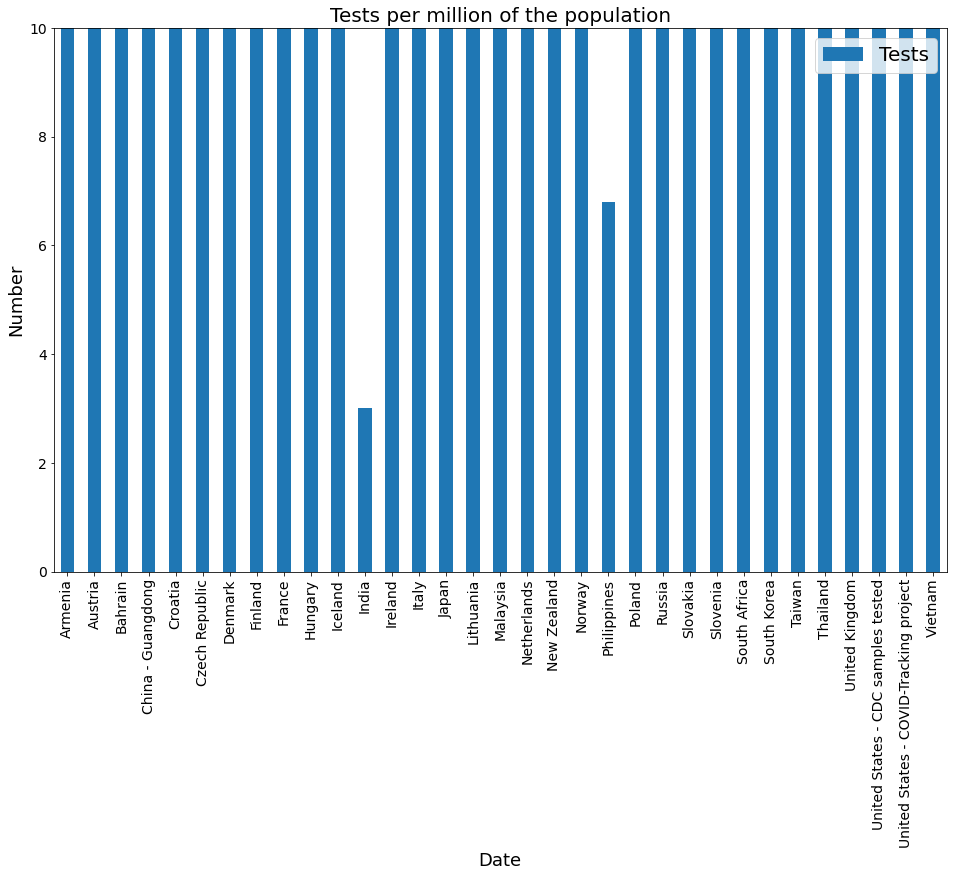

In [100]:
ax = tests_df.plot.bar()
#ax = tests_df.plot.scatter(x='Country', y='Tests', s=tests_df['Tests'] * 200);
ax.set_ylabel("Number", fontname="Arial", fontsize=18)
ax.set_xlabel("Date", fontname="Arial", fontsize=18)
ax.legend(loc=0, prop={'size': 20})
ax.set_ylim(0,10)
ax.set_title("Tests per million of the population", fontsize=20)
plt.xticks(rotation=90)